In [1]:
## Version futuresales lib required = 0.2.1

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.2.1
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: futuresales-denissimo
    Found existing installation: futuresales-denissimo 0.2.0
    Uninstalling futuresales-denissimo-0.2.0:
      Successfully uninstalled futuresales-denissimo-0.2.0


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, causation_1_percent
from neptune.new.types import File

import seaborn as sns
import neptune.new as neptune
import sklearn

/tmp/ipykernel_12676/1462014458.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [3]:
RUN_NAME = ''

creds = load_credentials('../../credentials.json')['projects']

run = neptune.init(
    run='FSEXP-3',
    tags=['spikes', 'chebyshev'],
    **creds['fs-exploration'])


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/denissimo/fs-exploration/e/FSEXP-3
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
task_df = {}

validation_x = pd.read_csv('../../tmp/baseline_validation_set.csv').drop(['valid_target', 'target'], axis=1)
submission_x = pd.read_csv('../../tmp/baseline_submission_set.csv')

idx = pd.read_csv('../../tmp/idx.csv').rename({'id': 'object_id'}, axis=1)

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv').drop('Unnamed: 0', axis=1)
task_df['dynamic'] = from_pickle('../../tmp/id_sales_test.pkl')

In [5]:
dynamic = task_df['dynamic']

# Chebyshev dynamic outliers

## Imagine that our serieses are poorly predicted and in most cases it values are quite stochastic. Than we need to find outliers (irregular dynamic). So we can assume outliers as objects with at least 1 month that is out of 95% predictable interval

### We know that 

::sigma::

In [6]:
dynamic.progress_apply(
    lambda row: (row[row != 0].max() - row[row != 0].mean()) / row[row != 0].std(),
    axis=1
)

  0%|          | 0/422577 [00:00<?, ?it/s]

/tmp/ipykernel_12676/2832788302.py:2: RuntimeWarning: invalid value encountered in double_scalars
  lambda row: (row[row != 0].max() - row[row != 0].mean()) / row[row != 0].std(),


id
54        NaN
114       NaN
174       NaN
234       NaN
294       NaN
           ..
1330036   NaN
1330090   NaN
1330142   NaN
1330150   NaN
1330156   NaN
Length: 422577, dtype: float64

In [8]:
res = _

In [9]:
res_non_one_spike = res.dropna()

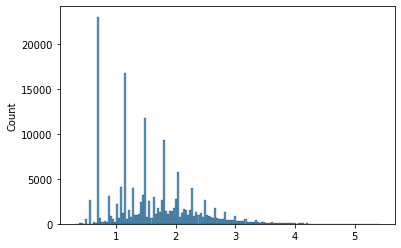

In [10]:
run['approaches/dynamic_outilers/sigma_value/histogram'] = File.as_image(sns.histplot(res_non_one_spike).figure)

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


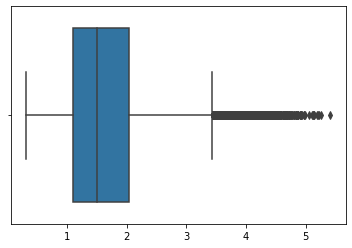

In [11]:
run['approaches/dynamic_outilers/sigma_value/whisker'] = File.as_image(sns.boxplot(res_non_one_spike).figure)

In [12]:
run['approaches/dynamic_outilers/count'] = res_non_one_spike[res_non_one_spike < 4].size

In [13]:
samples = res_non_one_spike[res_non_one_spike > 4.5].sort_values()
samples

id
528688     4.506827
478775     4.507374
400107     4.509901
527106     4.510899
525527     4.515550
             ...   
494371     5.184772
509946     5.204601
527065     5.218157
1317972    5.250636
509965     5.410236
Length: 107, dtype: float64

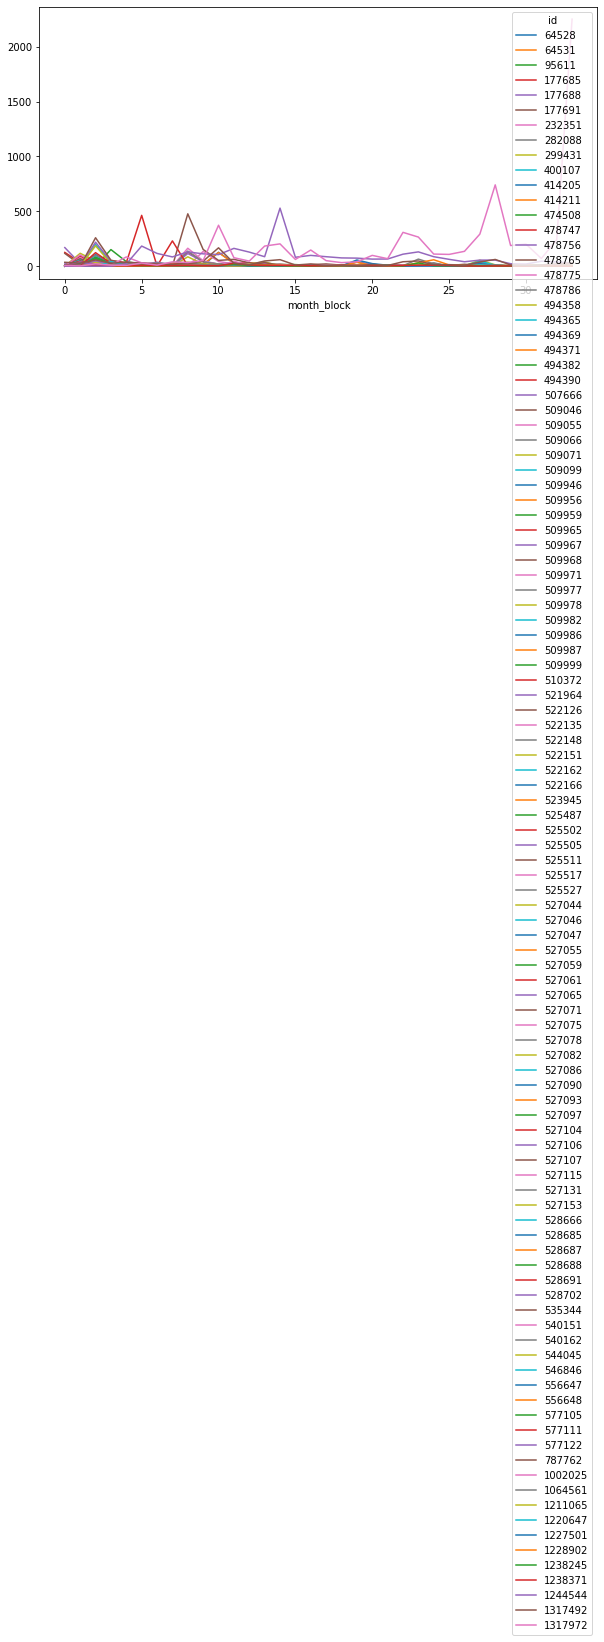

In [14]:
run['approaches/dynamic_outilers/sample_plots'] = File.as_image(task_df['dynamic'][task_df['dynamic'].index.isin(samples.index)].transpose().plot(figsize=(10, 5)).figure)

It founds useless old spikes that are irrelevant

In [15]:
validation_x

,id,lag_1,lag_2,lag_3,lag_4,lag_6,lag_12,dynamic_aggregation_mean_win_2,dynamic_aggregation_std_win_2,dynamic_aggregation_min_win_2,...,lags_12_aggregation_min_win_4,lags_12_aggregation_max_win_4,lags_12_aggregation_mean_win_6,lags_12_aggregation_std_win_6,lags_12_aggregation_min_win_6,lags_12_aggregation_max_win_6,lags_12_aggregation_mean_win_12,lags_12_aggregation_std_win_12,lags_12_aggregation_min_win_12,lags_12_aggregation_max_win_12
0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.083333,0.288675,0.0,1.0
1,114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.083333,0.288675,0.0,1.0
2,174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.166667,0.389249,0.0,1.0
3,234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.083333,0.288675,0.0,1.0
4,294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422572,1330036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
422573,1330090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.166667,0.408248,0.0,1.0,0.083333,0.288675,0.0,1.0
422574,1330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
422575,1330150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.166667,0.408248,0.0,1.0,0.083333,0.288675,0.0,1.0


In [16]:
some = (validation_x.diff_1_aggregation_max_win_2 - validation_x.diff_1_aggregation_mean_win_12) / validation_x.diff_1_aggregation_std_win_12

In [18]:
sub_some = (submission_x.diff_1_aggregation_max_win_2 - submission_x.diff_1_aggregation_mean_win_12) / submission_x.diff_1_aggregation_std_win_12

In [19]:
sub_some

0         NaN
1         0.0
2         NaN
3         NaN
4         0.0
         ... 
422572    NaN
422573    NaN
422574    NaN
422575    NaN
422576    NaN
Length: 422577, dtype: float64

<AxesSubplot:ylabel='Count'>

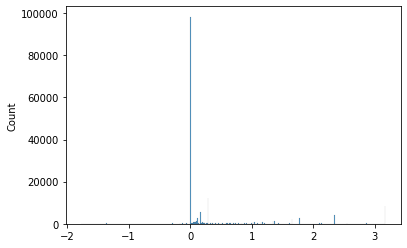

In [20]:
sns.histplot(sub_some)

In [17]:
assert False

AssertionError: 

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


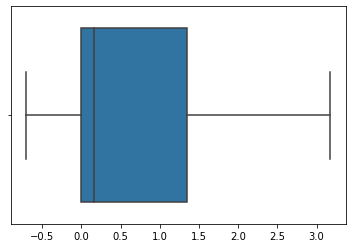

In [ ]:
run['approaches/diff_outilers/sigma_value/whisker'] = File.as_image(sns.boxplot(some).figure)

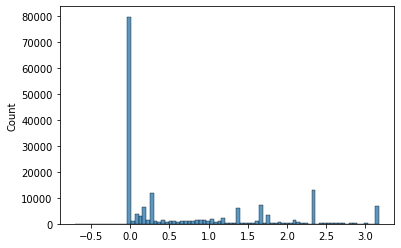

In [ ]:
run['approaches/diff_outilers/sigma_value/histogram'] = File.as_image(sns.histplot(some).figure)

<AxesSubplot:ylabel='Count'>

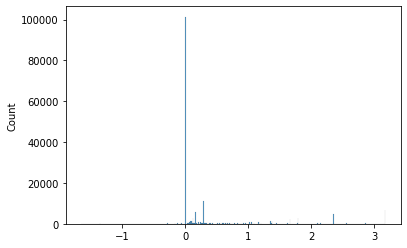

In [ ]:
sns.histplot(some)

In [37]:
outliers = some[abs(some) > 3]
objs = validation_x[validation_x.index.isin(outliers.index)].id
# run['approaches/diff_outilers/count'] = objs.size
objs.size

6847

In [49]:
submission_outliers = some[abs(sub_some) > 3]

submission_outliers = set(outliers.index) | set(submission_outliers.index)

submission_objs = validation_x[validation_x.index.isin(submission_outliers)].id
# run['approaches/diff_outilers/count'] = objs.size
submission_objs.size

14741

In [ ]:
fake_outliers = [1076071,
 1244527,
 1244557,
 1266595,
 1065266,
 1068042,
 1244578,
 1065262,
 1244573,
 1066509,
 1244568,
 1068025,
 1076082,
 1244534,
 302395,
 1076065,
 1326920,
 1065271,
 1095849,
 1076142,
 1244566,
 1285869,
 1287860,
 1065246,
 1321209,
 1244546,
 1244559,
 528429,
 1244576,
 1076125,
 519969,
 1244524,
 1076905,
 525789,
 1244577,
 1076922,
 1317792,
 1321220,
 1287849,
 1065282,
 1244541,
 1244567,
 1065265,
 900009,
 1244548,
 1244551,
 1244562,
 1244545,
 1244532,
 1317972]

In [ ]:
objs.isin(fake_outliers).sum()

0

<AxesSubplot:xlabel='month_block'>

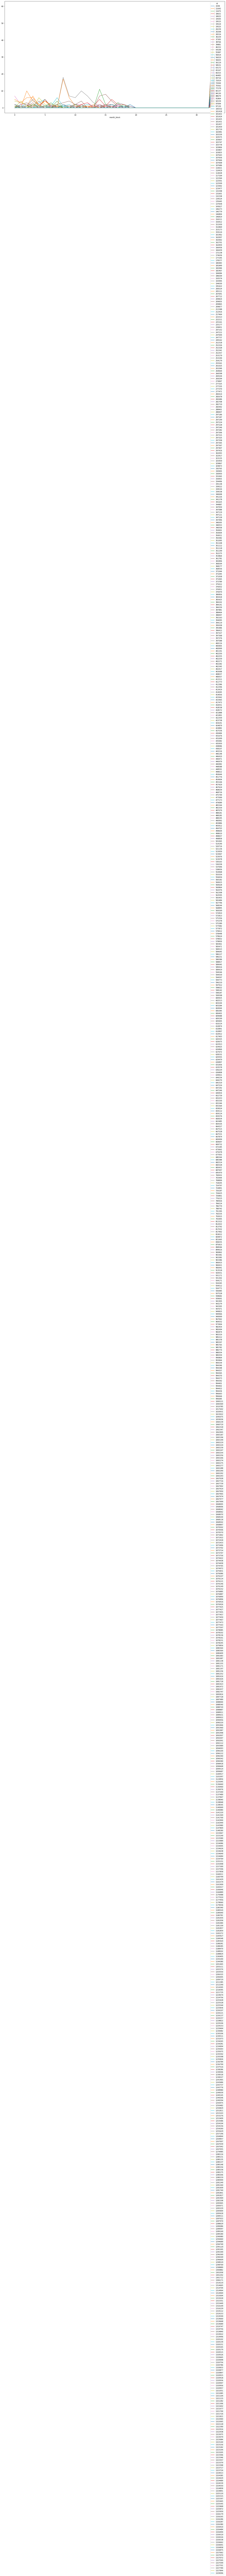

In [32]:
task_df['dynamic'][task_df['dynamic'].index.isin(submission_objs.sample(1000))].transpose().plot(figsize=(23, 12))

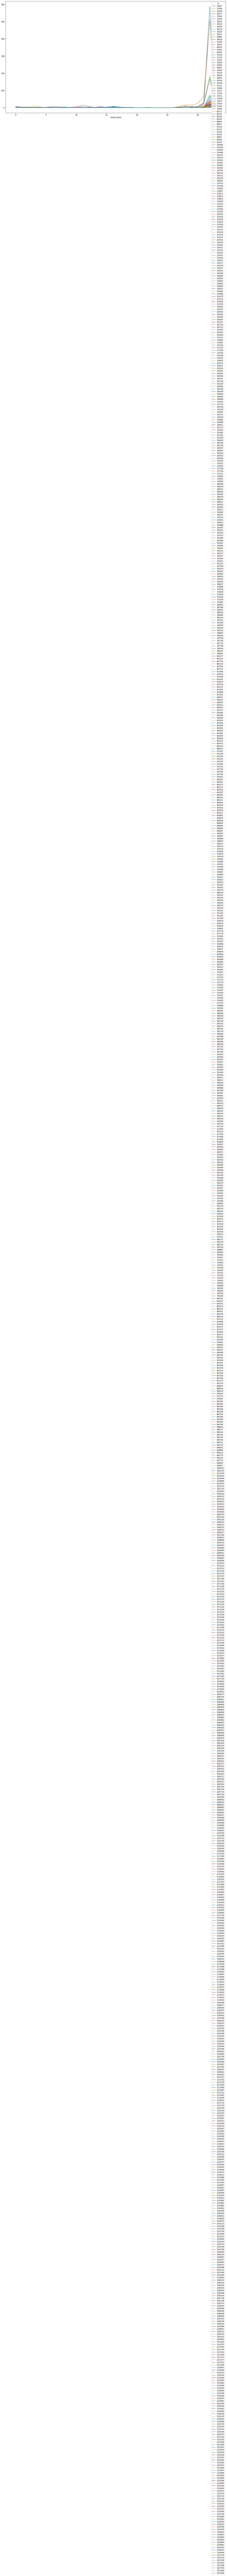

In [ ]:
run['approaches/diff_outilers/sample_plots'] = File.as_image(task_df['dynamic'][task_df['dynamic'].index.isin(objs.sample(1000))].transpose().plot(figsize=(23, 12)).figure)

In [50]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!


In [53]:
objs.shape, submission_objs.shape

((6847,), (14741,))

In [54]:
to_pickle('../../tmp/chebyshev_diff_outliers.pkl', objs)
to_pickle('../../tmp/chebyshev_diff_outliers_submission.pkl', submission_objs)